# CSS5228 Final Project

In this notebook, we will start training our model.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from math import sqrt
import gc

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import cv

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from src.utils import highlight_top, save_fig

import warnings
warnings.filterwarnings("ignore")

# Configurations

In [10]:
pd.set_option('display.max_columns', None)

In [16]:
sns.set_theme(style="ticks")
sns.set_context("paper", rc={"xtick.labelsize":15,
                             "ytick.labelsize":15,
                             "axes.titlesize":20,
                             "axes.labelsize":15})
default_col = '#4c72b0'
highlight_col = '#c44d52'

img_dir = Path("images/")

In [17]:
size=20
params = {'legend.fontsize': 'large',
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

# Import Data

In [18]:
df_train = pd.read_csv("../clean_data/train_preproc.csv", index_col=0)
df_test = pd.read_csv("../clean_data/test_preproc.csv", index_col=0)
df_submission = pd.read_csv("../raw_data/example-submission.csv")

In [20]:
df_train = df_train.drop(['property_type', 'subzone', 'planning_area'], axis=1)
df_test = df_test.drop(['property_type', 'subzone', 'planning_area'], axis=1)

In [21]:
X = df_train.drop("price", axis=1)
y = df_train["price"]
df_test = df_test.loc[:, X.columns]

# 1. Baseline Performance

- We will start off with ensemble tree methods since it doesn't require standardization and performs relatively well.
- We will also be able to leverage on the feature importance function to have a sense of how each feature is performing

In [8]:
model_selector = {"LGBM": LGBMRegressor(), 
                  "GradientBoost":GradientBoostingRegressor(), 
                  "XGBoost": XGBRegressor(),
                  "Random Forest": RandomForestRegressor(),
                  "CatBoost": CatBoostRegressor()}

In [9]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [10]:
for model_name in model_selector:
    print("=============")
    print("Model: {}".format(model_name))
    print("=============")
    fold_score = []
    
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
            
        print("\nFold {}".format(fold+1))
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]
        #print("Train shape: {}, {}, Valid shape: {}, {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
        
        model = model_selector[model_name]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        rmse_score = mean_squared_error(y_val, y_pred, squared=False)
        fold_score.append(rmse_score)
        print("Validation RMSE = {:.4f}".format(rmse_score))
    print("================================")
    print("RMSE = {}".format(np.mean(fold_score)))

Model: LGBM

Fold 1
Validation RMSE = 2012164.7489

Fold 2
Validation RMSE = 2291688.4314

Fold 3
Validation RMSE = 1243021.7422

Fold 4
Validation RMSE = 1478474.2824

Fold 5
Validation RMSE = 2122047.5485
RMSE = 1829479.350678829
Model: GradientBoost

Fold 1
Validation RMSE = 2399615.5648

Fold 2
Validation RMSE = 2456919.2962

Fold 3
Validation RMSE = 1506660.2248

Fold 4
Validation RMSE = 1797448.8762

Fold 5
Validation RMSE = 2360024.7215
RMSE = 2104133.7366830083
Model: XGBoost

Fold 1
Validation RMSE = 2252830.6262

Fold 2
Validation RMSE = 2130197.9979

Fold 3
Validation RMSE = 1319493.8997

Fold 4
Validation RMSE = 1789418.3106

Fold 5
Validation RMSE = 2014704.4274
RMSE = 1901329.052360861
Model: Random Forest

Fold 1
Validation RMSE = 2016152.9939

Fold 2
Validation RMSE = 2191690.7786

Fold 3
Validation RMSE = 1390162.5739

Fold 4
Validation RMSE = 1538453.0091

Fold 5
Validation RMSE = 2086602.8845
RMSE = 1844612.4479921504
Model: CatBoost

Fold 1
Learning rate set to 0.06

In [11]:
for model_name in model_selector:
    print("Model: {}".format(model_name))
        
    model = model_selector[model_name]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(df_test)
    df_submission[model_name] = y_pred


Model: LGBM
Model: GradientBoost
Model: XGBoost
Model: Random Forest
Model: CatBoost
Learning rate set to 0.063498
0:	learn: 4424153.6121018	total: 19.4ms	remaining: 19.4s
1:	learn: 4248116.9848167	total: 23.6ms	remaining: 11.8s
2:	learn: 4077099.6495236	total: 30.7ms	remaining: 10.2s
3:	learn: 3921477.9487308	total: 34.4ms	remaining: 8.58s
4:	learn: 3778932.8884769	total: 39ms	remaining: 7.76s
5:	learn: 3642234.2858030	total: 44.1ms	remaining: 7.31s
6:	learn: 3516995.5032800	total: 48.2ms	remaining: 6.84s
7:	learn: 3405110.5748284	total: 52.2ms	remaining: 6.47s
8:	learn: 3287800.5111950	total: 55.6ms	remaining: 6.12s
9:	learn: 3189405.1645287	total: 61.7ms	remaining: 6.11s
10:	learn: 3094772.8880886	total: 65.3ms	remaining: 5.87s
11:	learn: 3012164.8143284	total: 69.6ms	remaining: 5.73s
12:	learn: 2934549.9299303	total: 73.6ms	remaining: 5.59s
13:	learn: 2858864.2857682	total: 79ms	remaining: 5.56s
14:	learn: 2792066.6694338	total: 82.7ms	remaining: 5.43s
15:	learn: 2719889.8977276	to

In [12]:
df_submission["Predicted"] = df_submission[["LGBM", "GradientBoost", "XGBoost", "Random Forest", "CatBoost"]].mean(axis=1)

In [13]:
df_submission = df_submission.loc[:,["Id", "Predicted"]]

In [14]:
df_submission.to_csv("submissions/ensemble_no_tune.csv", index=0)

# 2. Hyperparameter Tuning

In [15]:
def objective_catboost(trial, X, y):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 1)
    param['depth'] = trial.suggest_int('depth', 3, 15, step=1)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5)
    param['grow_policy'] = 'Depthwise'
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
        
    cv_scores = np.empty(5)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for idx, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
            
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_valid, y_valid = X.iloc[val_idx,:], y[val_idx]
        
        regressor = CatBoostRegressor(**param)
        regressor.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    early_stopping_rounds=100, verbose = 0)
        
        y_pred = regressor.predict(X_valid)

        rmse_score = mean_squared_error(y_valid, y_pred, squared=False)
        cv_scores[idx] = rmse_score

    
    return np.mean(cv_scores)

In [16]:
%%time
study_catboost = optuna.create_study(direction="minimize", study_name="CatboostRegressor")
func = lambda trial: objective_catboost(trial, X, y)
study_catboost.optimize(func, n_trials=20, n_jobs=-1)

[I 2022-10-20 12:12:11,189] A new study created in memory with name: CatboostRegressor
[I 2022-10-20 12:12:50,010] Trial 9 finished with value: 1907891.793695822 and parameters: {'learning_rate': 0.18826854576597837, 'depth': 3, 'l2_leaf_reg': 4.132590299956581}. Best is trial 9 with value: 1907891.793695822.
[I 2022-10-20 12:13:01,458] Trial 1 finished with value: 2002644.167030502 and parameters: {'learning_rate': 0.5380903877545705, 'depth': 4, 'l2_leaf_reg': 1.124354821294248}. Best is trial 9 with value: 1907891.793695822.
[I 2022-10-20 12:13:15,517] Trial 12 finished with value: 1905258.2053774907 and parameters: {'learning_rate': 0.7673128029024506, 'depth': 4, 'l2_leaf_reg': 4.896322737431055}. Best is trial 12 with value: 1905258.2053774907.
[I 2022-10-20 12:13:24,442] Trial 5 finished with value: 1834524.9184192538 and parameters: {'learning_rate': 0.2852445815913286, 'depth': 6, 'l2_leaf_reg': 1.6122190367185438}. Best is trial 5 with value: 1834524.9184192538.
[I 2022-10-20

Wall time: 16min 57s


In [17]:
fig = optuna.visualization.plot_slice(study_catboost)
fig.update_layout(width=1200, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [18]:
fig = optuna.visualization.plot_param_importances(study_catboost)
fig.update_layout(width=800, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [19]:
def objective_xgb(trial, X, y):
    param = {}
    param['eta'] = trial.suggest_float("eta", 0.001, 1)
    param['max_depth'] = trial.suggest_int('max_depth', 3, 10, step=1)
    param['min_child_weight'] = trial.suggest_float('min_child_weight', 0.5, 5.5)
    param['alpha'] = trial.suggest_float('alpha', 0, 1)
    param['booster'] = 'gbtree'
    param['random_state'] = 42
    param['logging_level'] = 'Silent'

    cv_scores = np.empty(5)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for idx, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_valid, y_valid = X.iloc[val_idx,:], y[val_idx]
        
        regressor = XGBRegressor(**param)
        regressor.fit(X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    early_stopping_rounds=100,
                    verbose=0)
        
        y_pred = regressor.predict(X_valid)
        
        rmse_score = mean_squared_error(y_valid, y_pred, squared=False)
        cv_scores[idx] = rmse_score

    return np.mean(cv_scores)


In [20]:
%%time
study_xgb = optuna.create_study(direction="minimize", study_name="XGBoostRegressor")
func = lambda trial: objective_xgb(trial, X, y)
study_xgb.optimize(func, n_trials=20, n_jobs=-1)

[I 2022-10-20 12:32:14,535] A new study created in memory with name: XGBoostRegressor
[I 2022-10-20 12:32:27,013] Trial 11 finished with value: 2057270.488198518 and parameters: {'eta': 0.635372294831828, 'max_depth': 3, 'min_child_weight': 2.862685031737011, 'alpha': 0.9281475749423491}. Best is trial 11 with value: 2057270.488198518.
[I 2022-10-20 12:32:27,159] Trial 6 finished with value: 1954270.5627137255 and parameters: {'eta': 0.2837012904357285, 'max_depth': 3, 'min_child_weight': 0.610751237214875, 'alpha': 0.24290024766441454}. Best is trial 6 with value: 1954270.5627137255.
[I 2022-10-20 12:32:31,643] Trial 2 finished with value: 2040262.6680411622 and parameters: {'eta': 0.842129085751042, 'max_depth': 4, 'min_child_weight': 5.162351627711848, 'alpha': 0.7211868862327213}. Best is trial 6 with value: 1954270.5627137255.
[I 2022-10-20 12:32:32,514] Trial 9 finished with value: 1909180.948019325 and parameters: {'eta': 0.35506808867747297, 'max_depth': 4, 'min_child_weight': 

Wall time: 1min 2s


In [21]:
fig = optuna.visualization.plot_slice(study_xgb)
fig.update_layout(width=1200, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [22]:
fig = optuna.visualization.plot_param_importances(study_xgb)
fig.update_layout(width=800, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [23]:
def objective_rf(trial, X, y):
    param = {}
    # max_depth: depth of the tree
    param['max_depth'] = trial.suggest_int("max_depth", 3, 20, step=1)
    # min_sample_split: The minimum number of samples required to split an internal node:
    param['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 10, step=1)
    # n_estimators: the number of trees in the forest
    param['n_estimators'] = trial.suggest_int('n_estimators', 100, 1000, step=10)
    # max features: max_features
    param['max_features'] = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    param['random_state'] = 42

    cv_scores = np.empty(5)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for idx, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_valid, y_valid = X.iloc[val_idx,:], y[val_idx]
        
        regressor = RandomForestRegressor(**param)
        regressor.fit(X_train, y_train)
    
        y_pred = regressor.predict(X_valid)
        
        rmse_score = mean_squared_error(y_valid, y_pred, squared=False)
        cv_scores[idx] = rmse_score
    
    return np.mean(cv_scores)

In [24]:
%%time
study_rf = optuna.create_study(direction="minimize", study_name="Random Forest")
func = lambda trial: objective_rf(trial, X, y)
study_rf.optimize(func, n_trials=20, n_jobs=-1)

[I 2022-10-20 12:34:55,803] A new study created in memory with name: Random Forest
[I 2022-10-20 12:35:15,599] Trial 9 finished with value: 2682404.1412762622 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 240, 'max_features': 'log2'}. Best is trial 9 with value: 2682404.1412762622.
[I 2022-10-20 12:35:41,560] Trial 0 finished with value: 2009117.1747365699 and parameters: {'max_depth': 7, 'min_samples_split': 9, 'n_estimators': 320, 'max_features': 'sqrt'}. Best is trial 0 with value: 2009117.1747365699.
[I 2022-10-20 12:35:45,991] Trial 6 finished with value: 2273455.651201627 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 450, 'max_features': 'sqrt'}. Best is trial 0 with value: 2009117.1747365699.
[I 2022-10-20 12:35:52,701] Trial 1 finished with value: 2108034.4665110703 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'n_estimators': 440, 'max_features': 'log2'}. Best is trial 0 with value: 2009117.1747365699.
[I 2022-10

Wall time: 6min 40s


In [25]:
fig = optuna.visualization.plot_slice(study_rf)
fig.update_layout(width=1200, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [26]:
fig = optuna.visualization.plot_param_importances(study_rf)
fig.update_layout(width=800, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [27]:
def objective_lgbm(trial, X, y):
    param = {}
    # max_depth: Maximum tree depth for base learners,
    param['max_depth'] = trial.suggest_int("max_depth", 3, 20, step=1)
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 1)
    # min_sample_split: The minimum number of samples required to split an internal node:
    param['min_child_samples'] = trial.suggest_int('min_child_samples', 20, 100, step=1)
    # n_estimators:  Number of boosted trees to fit.
    param['n_estimators'] = trial.suggest_int('n_estimators', 100, 1000, step=10)
    param['boosting_type'] = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
    param['random_state'] = 42

    cv_scores = np.empty(5)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for idx, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_valid, y_valid = X.iloc[val_idx,:], y[val_idx]
        
        regressor = LGBMRegressor(**param)
        regressor.fit(X_train, y_train)
        
        y_pred = regressor.predict(X_valid)
        
        rmse_score = mean_squared_error(y_valid, y_pred, squared=False)
        cv_scores[idx] = rmse_score
    
    return np.mean(cv_scores)

In [28]:
%%time
study_lgbm = optuna.create_study(direction="minimize", study_name="LGBM")
func = lambda trial: objective_lgbm(trial, X, y)
study_lgbm.optimize(func, n_trials=20, n_jobs=-1)

[I 2022-10-20 12:45:14,540] A new study created in memory with name: LGBM
[I 2022-10-20 12:45:24,269] Trial 5 finished with value: 1971390.2697498533 and parameters: {'max_depth': 3, 'learning_rate': 0.25883342260139885, 'min_child_samples': 46, 'n_estimators': 180, 'boosting_type': 'dart'}. Best is trial 5 with value: 1971390.2697498533.
[I 2022-10-20 12:45:24,846] Trial 8 finished with value: 1927001.6443466838 and parameters: {'max_depth': 5, 'learning_rate': 0.8739008238613104, 'min_child_samples': 87, 'n_estimators': 170, 'boosting_type': 'goss'}. Best is trial 8 with value: 1927001.6443466838.
[I 2022-10-20 12:45:27,756] Trial 7 finished with value: 1878146.9663722855 and parameters: {'max_depth': 4, 'learning_rate': 0.3071854428507924, 'min_child_samples': 72, 'n_estimators': 300, 'boosting_type': 'goss'}. Best is trial 7 with value: 1878146.9663722855.
[I 2022-10-20 12:45:35,254] Trial 12 finished with value: 1959157.8046631808 and parameters: {'max_depth': 18, 'learning_rate':

Wall time: 2min 18s


In [29]:
fig = optuna.visualization.plot_slice(study_lgbm)
fig.update_layout(width=1200, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [30]:
fig = optuna.visualization.plot_param_importances(study_lgbm)
fig.update_layout(width=800, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [31]:
def objective_gradientboost(trial, X, y):
    param = {}

    param['max_depth'] = trial.suggest_int("max_depth", 3, 20, step=1)
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 1)
    param['min_samples_split'] = trial.suggest_int('min_samples_split', 2, 50, step=1)
    param['n_estimators'] = trial.suggest_int('n_estimators', 100, 1000, step=10)
    param['random_state'] = 42

    cv_scores = np.empty(5)
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for idx, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_valid, y_valid = X.iloc[val_idx,:], y[val_idx]
        
        regressor = GradientBoostingRegressor(**param)
        regressor.fit(X_train, y_train)
        
        y_pred = regressor.predict(X_valid)
        
        rmse_score = mean_squared_error(y_valid, y_pred, squared=False)
        cv_scores[idx] = rmse_score
    
    return np.mean(cv_scores)

In [32]:
%%time
study_gb = optuna.create_study(direction="minimize", study_name="Gradient Boosting")
func = lambda trial: objective_gradientboost(trial, X, y)
study_gb.optimize(func, n_trials=20, n_jobs=-1)

[I 2022-10-20 12:56:14,532] A new study created in memory with name: Gradient Boosting
[I 2022-10-20 12:57:48,785] Trial 6 finished with value: 2517719.6058097733 and parameters: {'max_depth': 5, 'learning_rate': 0.9226249848507485, 'min_samples_split': 50, 'n_estimators': 190}. Best is trial 6 with value: 2517719.6058097733.
[I 2022-10-20 12:58:52,712] Trial 0 finished with value: 2148905.374158939 and parameters: {'max_depth': 17, 'learning_rate': 0.6305943328050129, 'min_samples_split': 45, 'n_estimators': 100}. Best is trial 0 with value: 2148905.374158939.
[I 2022-10-20 13:00:05,757] Trial 3 finished with value: 1924078.1389242397 and parameters: {'max_depth': 11, 'learning_rate': 0.3788449871816189, 'min_samples_split': 22, 'n_estimators': 220}. Best is trial 3 with value: 1924078.1389242397.
[I 2022-10-20 13:00:38,324] Trial 8 finished with value: 1821124.1449801414 and parameters: {'max_depth': 8, 'learning_rate': 0.3659433345299187, 'min_samples_split': 10, 'n_estimators': 340

Wall time: 21min 59s


In [33]:
fig = optuna.visualization.plot_slice(study_gb)
fig.update_layout(width=1200, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [34]:
fig = optuna.visualization.plot_param_importances(study_gb)
fig.update_layout(width=800, height=500)
plt.tight_layout()
fig.show()

<Figure size 432x288 with 0 Axes>

In [35]:
def best_params(study):
    print(f"\tBest value (rmse): {study.best_value:.5f}")
    print(f"\tBest params:")

    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")

In [36]:
best_params(study_catboost)

	Best value (rmse): 1740670.09915
	Best params:
		learning_rate: 0.037928671921175466
		depth: 14
		l2_leaf_reg: 4.17622444252202


In [37]:
best_params(study_xgb)

	Best value (rmse): 1794170.80038
	Best params:
		eta: 0.28451882286215513
		max_depth: 8
		min_child_weight: 1.5699613027665738
		alpha: 0.06965957914298004


In [38]:
best_params(study_rf)

	Best value (rmse): 1759765.34498
	Best params:
		max_depth: 18
		min_samples_split: 4
		n_estimators: 460
		max_features: log2


In [39]:
best_params(study_lgbm)

	Best value (rmse): 1779824.07739
	Best params:
		max_depth: 20
		learning_rate: 0.09949156099870674
		min_child_samples: 28
		n_estimators: 810
		boosting_type: dart


In [40]:
best_params(study_gb)

	Best value (rmse): 1821124.14498
	Best params:
		max_depth: 8
		learning_rate: 0.3659433345299187
		min_samples_split: 10
		n_estimators: 340


# 3. Model Training with best params

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_valid)))
print(len(X_valid), len(y_valid))

Size of training set: 16076
Size of test: 4020
4020 4020


In [42]:
model_selector = {"LGBM": LGBMRegressor(**study_lgbm.best_params), 
                  "XGBoost": XGBRegressor(**study_xgb.best_params),
                  "Random Forest": RandomForestRegressor(**study_rf.best_params),
                  "Gradient Boost": GradientBoostingRegressor(**study_gb.best_params),
                  "CatBoost": CatBoostRegressor(**study_catboost.best_params)}

In [43]:
for model_name in model_selector:
    print("=============")
    print("Model: {}".format(model_name))
    print("=============")
    fold_score = []
    
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
            
        print("\nFold {}".format(fold+1))
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]
        #print("Train shape: {}, {}, Valid shape: {}, {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
        
        model = model_selector[model_name]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        rmse_score = mean_squared_error(y_val, y_pred, squared=False)
        fold_score.append(rmse_score)
        print("Validation RMSE = {:.4f}".format(rmse_score))
    print("================================")
    print("RMSE = {}".format(np.mean(fold_score)))

Model: LGBM

Fold 1
Validation RMSE = 2122314.8077

Fold 2
Validation RMSE = 2235573.2474

Fold 3
Validation RMSE = 1147744.1767

Fold 4
Validation RMSE = 1419321.8838

Fold 5
Validation RMSE = 1980035.1176
RMSE = 1780997.8466390292
Model: XGBoost

Fold 1
Validation RMSE = 2114375.2443

Fold 2
Validation RMSE = 2191627.0120

Fold 3
Validation RMSE = 1575776.7713

Fold 4
Validation RMSE = 1480312.7576

Fold 5
Validation RMSE = 1718107.8624
RMSE = 1816039.9295153837
Model: Random Forest

Fold 1
Validation RMSE = 2110524.7599

Fold 2
Validation RMSE = 2244180.2079

Fold 3
Validation RMSE = 1131022.2333

Fold 4
Validation RMSE = 1348583.2207

Fold 5
Validation RMSE = 2012462.4733
RMSE = 1769354.5790024926
Model: Gradient Boost

Fold 1
Validation RMSE = 1838943.1363

Fold 2
Validation RMSE = 2177429.3015

Fold 3
Validation RMSE = 1438834.7808

Fold 4
Validation RMSE = 1479503.4436

Fold 5
Validation RMSE = 1934238.7845
RMSE = 1773789.8893526983
Model: CatBoost

Fold 1
0:	learn: 4512463.0472

In [44]:
def plot_importance(importances, img_dir, model_name, features):
    
    indices = np.argsort(importances)
    
    fig, ax = plt.subplots(figsize=(10,8))   
    title_name = "{} Feature Importance".format(model_name)
    plt.title(title_name)
    plt.barh(range(len(indices)), importances[indices], color=default_col, align='center')
    highlight_top(ax, "horizontal", highlight_col)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    figure_name = "feature_importance_{}".format(model_name)
    save_fig(figure_name, img_dir)
    plt.show()
 


Model: LGBM
Saving figure feature_importance_LGBM


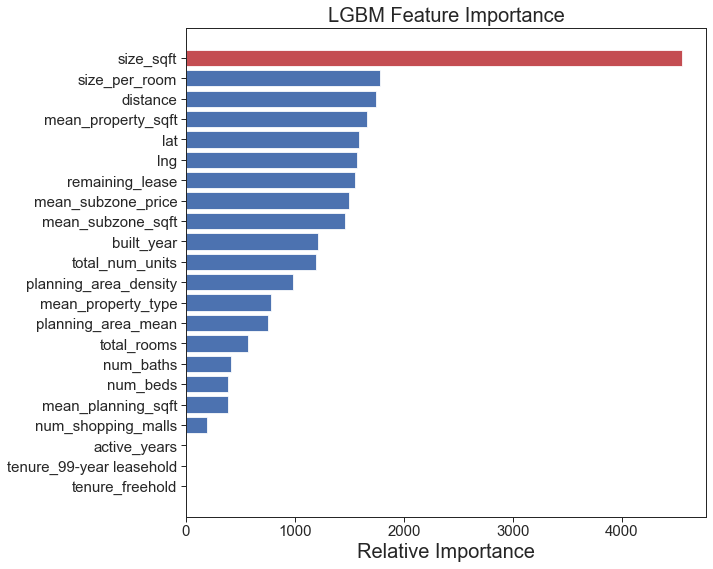

Model: XGBoost
Saving figure feature_importance_XGBoost


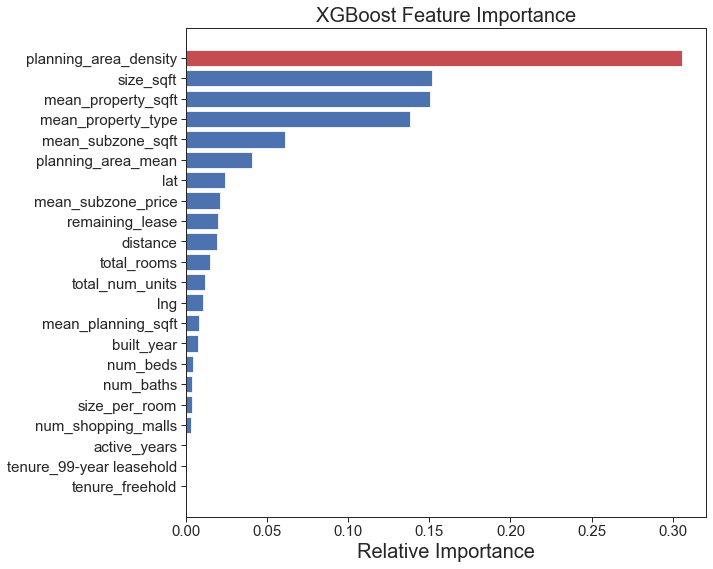

Model: Random Forest
Saving figure feature_importance_Random Forest


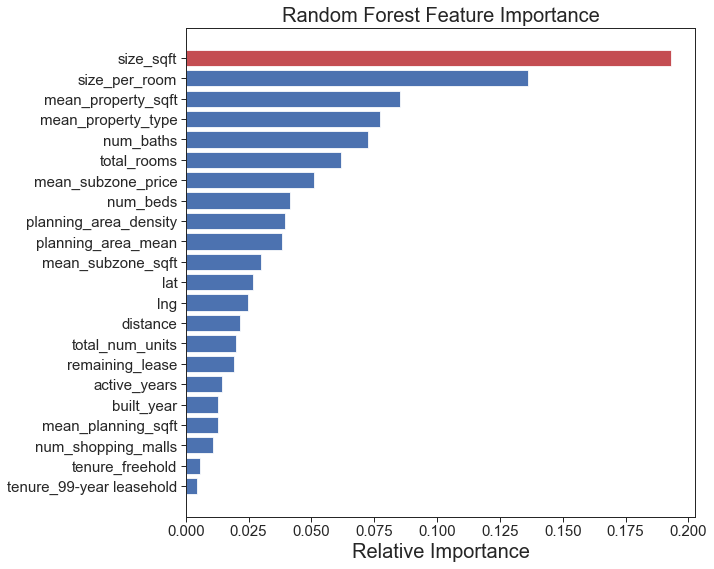

Model: Gradient Boost
Saving figure feature_importance_Gradient Boost


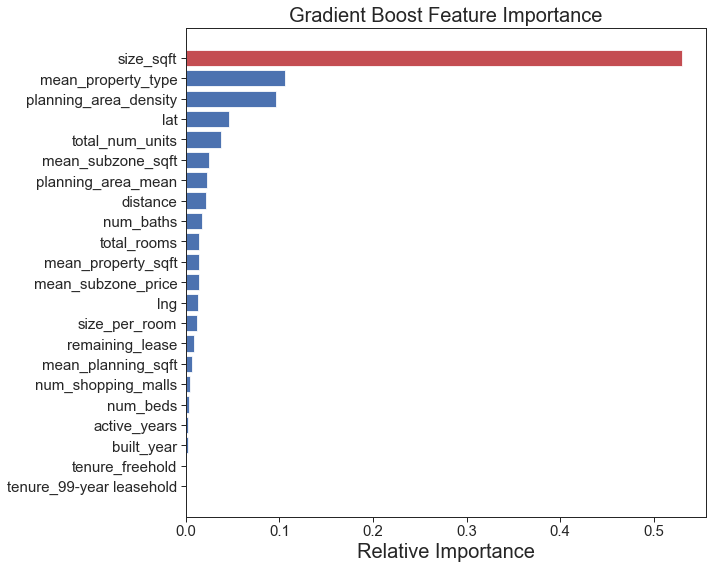

Model: CatBoost
0:	learn: 4505544.0386648	total: 632ms	remaining: 10m 31s
1:	learn: 4396150.8364824	total: 1.29s	remaining: 10m 44s
2:	learn: 4287104.4552009	total: 1.53s	remaining: 8m 29s
3:	learn: 4186354.7664972	total: 1.78s	remaining: 7m 24s
4:	learn: 4085625.3930522	total: 2.51s	remaining: 8m 20s
5:	learn: 3996458.7359533	total: 3.2s	remaining: 8m 49s
6:	learn: 3904326.1794715	total: 3.94s	remaining: 9m 18s
7:	learn: 3812558.4325403	total: 4.54s	remaining: 9m 22s
8:	learn: 3727036.4730830	total: 5.08s	remaining: 9m 19s
9:	learn: 3644829.8080586	total: 5.6s	remaining: 9m 14s
10:	learn: 3566980.1187204	total: 6.05s	remaining: 9m 4s
11:	learn: 3490000.4067620	total: 6.5s	remaining: 8m 54s
12:	learn: 3422651.7641589	total: 7.02s	remaining: 8m 53s
13:	learn: 3350247.8787922	total: 7.55s	remaining: 8m 51s
14:	learn: 3282468.0149810	total: 8.05s	remaining: 8m 48s
15:	learn: 3216246.5712440	total: 8.55s	remaining: 8m 45s
16:	learn: 3148918.1494189	total: 9.08s	remaining: 8m 45s
17:	learn:

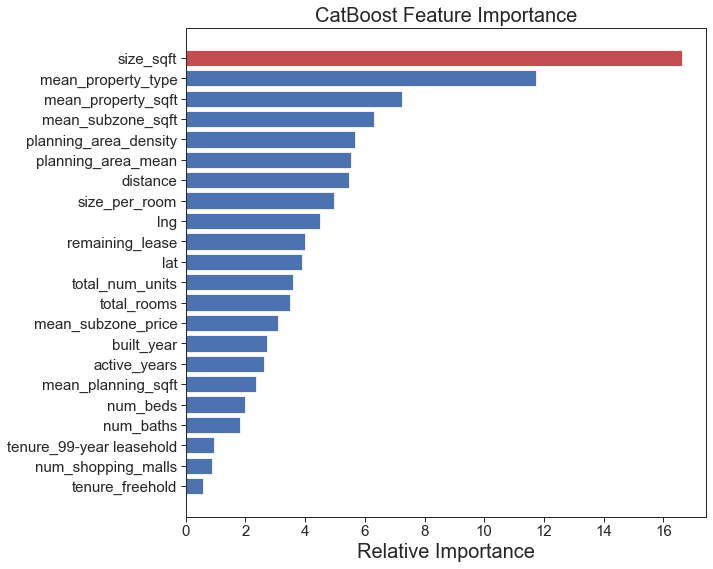

In [45]:
features = X.columns
for model_name in model_selector:
    print("Model: {}".format(model_name))
        
    model = model_selector[model_name]
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    plot_importance(importances, img_dir, model_name, features)
    y_pred = model.predict(df_test)
    df_submission[model_name] = y_pred

In [46]:
df_submission.head()

,Id,Predicted,LGBM,XGBoost,Random Forest,Gradient Boost,CatBoost
0,0,1.189233e+06,1.168853e+06,1.159827e+06,1.166846e+06,1.165842e+06,1.159225e+06
1,1,1.465474e+06,1.495944e+06,1.383428e+06,1.489194e+06,1.416449e+06,1.515767e+06
2,2,1.152185e+06,1.154534e+06,1.155147e+06,1.177987e+06,1.158655e+06,1.130753e+06
3,3,7.587755e+05,7.336881e+05,7.742206e+05,6.951252e+05,7.269933e+05,7.344260e+05
4,4,5.843215e+05,6.091294e+05,6.540398e+05,5.864138e+05,6.045588e+05,5.220807e+05


In [47]:
df_submission["Predicted"] = df_submission[["LGBM", "XGBoost", "Random Forest", "Gradient Boost", "CatBoost"]].mean(axis=1)
df_submission = df_submission.loc[:,["Id", "Predicted"]]

In [48]:
df_submission.head()

,Id,Predicted
0,0,1.164119e+06
1,1,1.460156e+06
2,2,1.155415e+06
3,3,7.328906e+05
4,4,5.952445e+05


In [49]:
df_submission.to_csv("submissions/ensemble_with_tuning_all.csv", index=0)